<a href="https://colab.research.google.com/github/IanRic32/1822-Almacenando-Datos-En-El-Navegador/blob/projectoInicial/Ejercicio_salud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Buscamos una predicción para el importe de factura, para ello podemos empezar con un analisis estadistico de todos nuestros datos, para encontrar incosistencias <br>
Comenzamos importando las librerias necesarias para el tratamiento


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statistics import stdev, mean
from scipy.stats import kstest, norm

In [5]:
data_eda = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/healthcare_dataset.csv")

Una vez importada la base de datos, veamos la información que nos proporciona cada variable

In [6]:
data_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                10000 non-null  object 
 1   Age                 10000 non-null  int64  
 2   Gender              10000 non-null  object 
 3   Blood Type          10000 non-null  object 
 4   Medical Condition   10000 non-null  object 
 5   Date of Admission   10000 non-null  object 
 6   Doctor              10000 non-null  object 
 7   Hospital            10000 non-null  object 
 8   Insurance Provider  10000 non-null  object 
 9   Billing Amount      10000 non-null  float64
 10  Room Number         10000 non-null  int64  
 11  Admission Type      10000 non-null  object 
 12  Discharge Date      10000 non-null  object 
 13  Medication          10000 non-null  object 
 14  Test Results        10000 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 1.1+

Con ello podemos hacer la traducción de las columnas al español, solo por conveniencia

In [7]:
columnas_ingles = data_eda.columns.to_list()
columnas_esp = ['Nombre','Edad','Sexo', "Tipo de sangre", "condición médica", "Fecha de admisión",'Médico',
 "Hospital", 'Proveedor de seguro', "Importe de la factura", "Número de habitación", "Tipo de ingreso",
 "Fecha de alta","Medicación","Resultados de pruebas"]
columnas = dict(zip(columnas_ingles,columnas_esp))

In [8]:
data_eda = data_eda.rename(columns=columnas)

Una vez hecho esto, podemos ver el tiempo que estan las personas internadas, usando la diferencia entre la fecha de alta y la fecha de admision, si existiera alguna incosistencia entre las fechas, podriamos tener dias negativos, lo cual nos diria que dieron de alta a una persona antes de que sea admitida en el hospital

In [9]:
data_eda['Fecha de admisión'] = pd.to_datetime(data_eda["Fecha de admisión"])
data_eda['Fecha de alta'] = pd.to_datetime(data_eda["Fecha de alta"])
data_eda['Tiempo de estancia'] = (data_eda['Fecha de alta'] - data_eda['Fecha de admisión']).dt.days
data_eda["Tiempo de estancia"]

0       14
1       14
2       30
3        1
4       24
        ..
9995     4
9996    23
9997    14
9998    20
9999    24
Name: Tiempo de estancia, Length: 10000, dtype: int64

Veamos si existen registros con dias de internado menores a 0

In [10]:
tiempo_estancia_negativo = data_eda[data_eda["Tiempo de estancia"] < 0]["Tiempo de estancia"]
print(tiempo_estancia_negativo)


Series([], Name: Tiempo de estancia, dtype: int64)


Podemos notar que no existe, registro alguno, por lo cual, es posible concluir que no existen datos incosistentes con respecto fechas de admisión y de alta <br>
Observemos cuanto pagan aproximidamente por dia de estancia

In [26]:
media = data_eda[["Tiempo de estancia", "Importe de la factura"]].groupby("Tiempo de estancia").mean()
media

,Importe de la factura
Tiempo de estancia,
1,25082.474164
2,25799.141905
3,25840.947564
4,25541.612081
5,25280.005151
6,25926.318604
7,26899.751165
8,25077.025803
9,26622.867648


In [27]:
media_de_medias = mean(media["Importe de la factura"].to_list())
media_de_medias

25520.210424949753

Gracias a esto, podemos ver una gran incosistencia, no importa los dias que esten internados el costo promedio por estancia, sin importar la cantidad de dias, es de aproximidamente $ 25520.210424949753. dolares

## Busqueda de nombres duplicados
Aclarando que es posible que existan nombres duplicados, dado que es posible que existan más de dos personas con los mismos nombres o que un solo individuo aparesca en más de una ocasión en la base de datos, dado que puede ingresar más de una vez al hospital.

Analizando estas inconsistencias puedemos filtrar la base de datos a personas con los mismos nombres y el mismo tipo de sangre para ver si es el mismo paciente.


In [40]:
nombres_dup = data_eda[data_eda["Nombre"].isin(data_eda[data_eda["Nombre"].duplicated()]["Nombre"])].sort_values(by=['Nombre'])
duplicados_mismo_tipo_sangre = data_eda[
    (data_eda["Nombre"].isin(nombres_dup["Nombre"])) &
    (data_eda.duplicated(subset=["Nombre", "Tipo de sangre"], keep=False))
].sort_values(by=['Nombre'])
duplicados_mismo_tipo_sangre

,Nombre,Edad,Sexo,Tipo de sangre,condición médica,Fecha de admisión,Médico,Hospital,Proveedor de seguro,Importe de la factura,Número de habitación,Tipo de ingreso,Fecha de alta,Medicación,Resultados de pruebas,Tiempo de estancia
2870,Amanda Williams,82,Female,A+,Obesity,2021-11-07,Angel King,Wallace Inc,UnitedHealthcare,24307.581438,105,Urgent,2021-11-11,Aspirin,Normal,4
3691,Amanda Williams,60,Male,A+,Asthma,2020-08-14,Adriana Hall,"Mcintosh, Massey and Hayes",Cigna,28949.749530,473,Urgent,2020-08-24,Ibuprofen,Abnormal,10
7757,Amy Brown,40,Male,AB+,Cancer,2021-08-07,Jesse Dixon,"Jensen, Kemp and Vega",Blue Cross,22519.030420,302,Emergency,2021-08-25,Penicillin,Abnormal,18
7689,Amy Brown,76,Male,AB+,Arthritis,2020-01-26,Theresa Morris,"Gibson, Brown and Maxwell",Cigna,35637.277061,306,Elective,2020-02-11,Lipitor,Inconclusive,16
8988,Anthony Young,49,Male,AB+,Arthritis,2022-02-09,Tracy Garza,"James, Skinner and Trevino",Cigna,26631.294280,406,Elective,2022-02-17,Paracetamol,Inconclusive,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373,Thomas Long,24,Female,O+,Diabetes,2021-04-10,Valerie Ellis,Ross-Murphy,Cigna,19107.628070,336,Elective,2021-04-14,Penicillin,Normal,4
1658,Timothy Smith,79,Female,B+,Asthma,2022-02-08,Tammy Lambert,"Estes, Burns and Perez",Cigna,28154.494737,433,Urgent,2022-02-13,Paracetamol,Abnormal,5
8450,Timothy Smith,78,Male,B+,Hypertension,2022-10-08,Craig Harris,"Barnes, Perry and Barnes",Blue Cross,11190.703992,168,Emergency,2022-10-27,Aspirin,Inconclusive,19
1280,William Johnson,20,Male,AB+,Arthritis,2019-06-21,Arthur Hall,Taylor and Sons,Blue Cross,39952.384856,145,Elective,2019-07-13,Lipitor,Inconclusive,22


Se observa que existen 202 registros donde hay nombre duplicados y personas con el mismo tipo de sangre, pero son de sexos diferentes, por lo cual no podemos concluir que una persona alla asistido más de una vez al hospital.
Busquemos por:


*   Nombre
*   Edad
*   Sexo
*   Tipo de sangre



In [45]:
duplicados_mismo_tipo_sangre = data_eda[
    (data_eda["Nombre"].isin(nombres_dup["Nombre"])) &
    (data_eda.duplicated(subset=["Nombre", "Tipo de sangre","Edad","Sexo"], keep=False))
].sort_values(by=['Nombre'])
print(len(duplicados_mismo_tipo_sangre ))

0


Realizando la busqueda con esas variables, podemos ver que no hay registros repetidos.
No podemos definir que sea atipico el hecho de que se encuentren mismos nombres con mismos tipos de sangre pero diferente sexo, esto por el simple hecho de como se identifique la persona.

Busquemos el costo por enfermedad

In [51]:
data_eda[["condición médica", "Importe de la factura"]].groupby("condición médica").mean()

,Importe de la factura
condición médica,
Arthritis,25187.631255
Asthma,25416.869895
Cancer,25539.096133
Diabetes,26060.116129
Hypertension,25198.033973
Obesity,25720.842683


In [52]:
data_eda[["Tipo de ingreso", "Importe de la factura"]].groupby("Tipo de ingreso").mean()

,Importe de la factura
Tipo de ingreso,
Elective,25891.832668
Emergency,24708.511933
Urgent,25960.833557


Comparando la condicion medica con los tiempos de estancia y el tipo de ingreso, podriamos observar que independientemente de la condición medica, tipo de ingreso y el tiempo de estancia, el precio promedio sigue siendo mayor a $ 20,000.00 dolares.
## Graficas

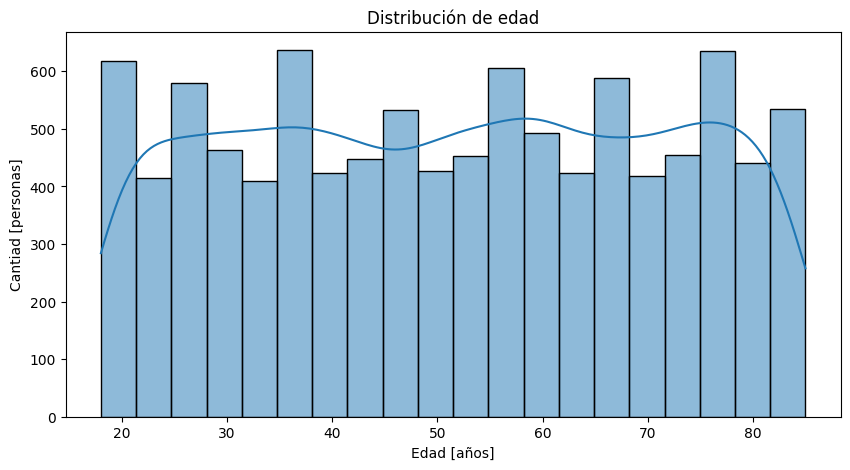

In [53]:

plt.figure(figsize=(10, 5))
sns.histplot(data_eda['Edad'], bins=20, kde=True)
plt.xlabel('Edad [años]')
plt.ylabel('Cantiad [personas]')
plt.title('Distribución de edad')
plt.show()

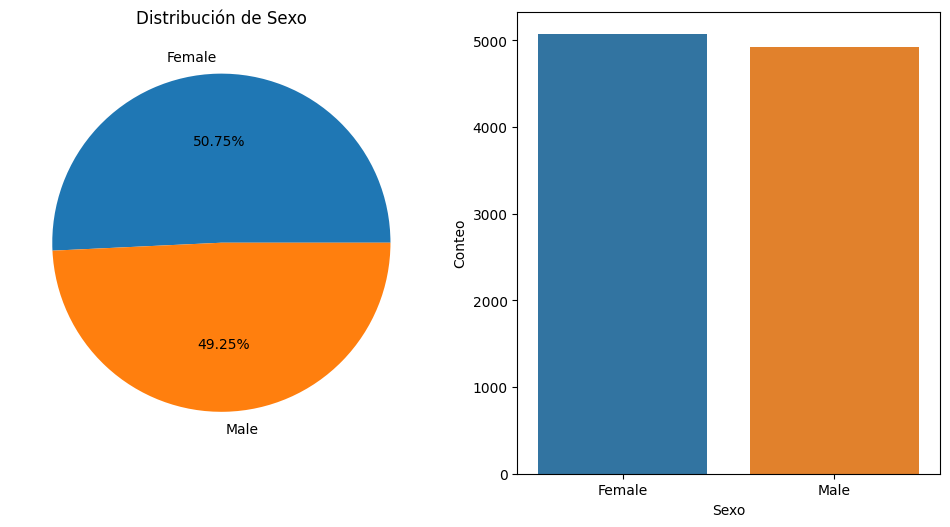

In [61]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sexo = data_eda['Sexo'].value_counts()
labels = sexo.index
plt.pie(sexo, labels=labels, autopct="%.2f%%")
plt.title("Distribución de Sexo")
plt.subplot(1,2,2)
sns.countplot(x='Sexo', data=data_eda)
plt.xlabel('Sexo')
plt.ylabel('Conteo')
plt.show()

Encontramos una distribución casi uniforme, pero podemos aplicar una prueba para ver si son datos uniformemente distribuidos o normalmente distribuidos, haciendo que la variable sexo sea binaria, con 0 si es mujer y 1 si es hombre

In [71]:
data_dummy_sexo = data_eda.copy()

In [72]:
genero = list(data_dummy_sexo["Sexo"].unique())
data_dummy_sexo["Sexo"] = data_dummy_sexo["Sexo"].replace({f"{genero[0]}":0,f"{genero[1]}":1})
data_dummy_sexo = data_dummy_sexo.drop(["Nombre","Número de habitación"],axis=1)

In [74]:
columna_a_probar = data_dummy_sexo["Importe de la factura"]
# Aplicamos la prueba de Kolmogorov-Smirnov
resultado_prueba = kstest(columna_a_probar, 'uniform', alternative='two-sided')
print("Estadística de la prueba:", resultado_prueba.statistic)
print("Valor p:", resultado_prueba.pvalue)
alpha = 0.05
if resultado_prueba.pvalue < alpha:
    print("Rechazamos la hipótesis nula. Los datos no siguen una distribución uniforme.")
else:
    print("No podemos rechazar la hipótesis nula. Los datos siguen una distribución uniforme.")

Estadística de la prueba: 0.5075
Valor p: 0.0
Rechazamos la hipótesis nula. Los datos no siguen una distribución uniforme.


In [75]:
columna_a_probar = data_dummy_sexo["Sexo"]
# Obtenemos los parámetros de la distribución normal de la columna
media, desviacion_estandar = norm.fit(columna_a_probar)
# Generamos una distribución normal con los parámetros ajustados
distribucion_normal = np.random.normal(media, desviacion_estandar, len(columna_a_probar))
# Aplicamos la prueba de Kolmogorov-Smirnov
resultado_prueba = kstest(columna_a_probar, 'norm', args=(media, desviacion_estandar), alternative='two-sided')
print("Estadística de la prueba:", resultado_prueba.statistic)
print("Valor p:", resultado_prueba.pvalue)
alpha = 0.05  # Nivel de significancia
if resultado_prueba.pvalue < alpha:
    print("Rechazamos la hipótesis nula. Los datos no siguen una distribución normal.")
else:
    print("No podemos rechazar la hipótesis nula. Los datos siguen una distribución normal.")

Estadística de la prueba: 0.3452151831771375
Valor p: 0.0
Rechazamos la hipótesis nula. Los datos no siguen una distribución normal.


Nos dice que no siguen distribuciones uniforme ni normal, lo cual es un tanto raro. <br>
Realizando la misma prueba para importe de factura

In [76]:
columna_a_probar = data_dummy_sexo["Importe de la factura"]
# Obtenemos los parámetros de la distribución normal de la columna
media, desviacion_estandar = norm.fit(columna_a_probar)
# Generamos una distribución normal con los parámetros ajustados
distribucion_normal = np.random.normal(media, desviacion_estandar, len(columna_a_probar))
# Aplicamos la prueba de Kolmogorov-Smirnov
resultado_prueba = kstest(columna_a_probar, 'norm', args=(media, desviacion_estandar), alternative='two-sided')
print("Estadística de la prueba:", resultado_prueba.statistic)
print("Valor p:", resultado_prueba.pvalue)
alpha = 0.05  # Nivel de significancia
if resultado_prueba.pvalue < alpha:
    print("Rechazamos la hipótesis nula. Los datos no siguen una distribución normal.")
else:
    print("No podemos rechazar la hipótesis nula. Los datos siguen una distribución normal.")

Estadística de la prueba: 0.05889983486800332
Valor p: 1.3438448218823003e-30
Rechazamos la hipótesis nula. Los datos no siguen una distribución normal.


In [77]:
columna_a_probar = data_dummy_sexo["Sexo"]
# Aplicamos la prueba de Kolmogorov-Smirnov
resultado_prueba = kstest(columna_a_probar, 'uniform', alternative='two-sided')
print("Estadística de la prueba:", resultado_prueba.statistic)
print("Valor p:", resultado_prueba.pvalue)
alpha = 0.05
if resultado_prueba.pvalue < alpha:
    print("Rechazamos la hipótesis nula. Los datos no siguen una distribución uniforme.")
else:
    print("No podemos rechazar la hipótesis nula. Los datos siguen una distribución uniforme.")

Estadística de la prueba: 0.5075
Valor p: 0.0
Rechazamos la hipótesis nula. Los datos no siguen una distribución uniforme.


Los importes de factura, tampoco siguen algun tipo de distribucion normal ni uniforme.

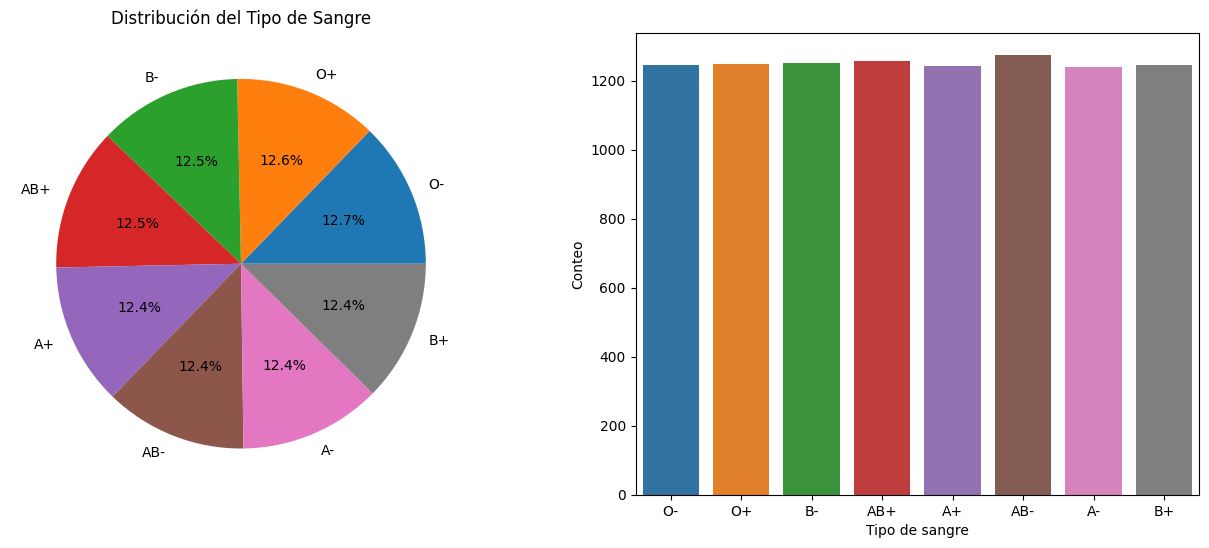

In [79]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.pie(data_eda['Tipo de sangre'].value_counts(), labels=data_eda['Tipo de sangre'].unique(), autopct='%1.1f%%')
plt.title('Distribución del Tipo de Sangre')
plt.subplot(1,2,2)
sns.countplot(x='Tipo de sangre', data=data_eda)
plt.xlabel('Tipo de sangre')
plt.ylabel('Conteo')
plt.show()

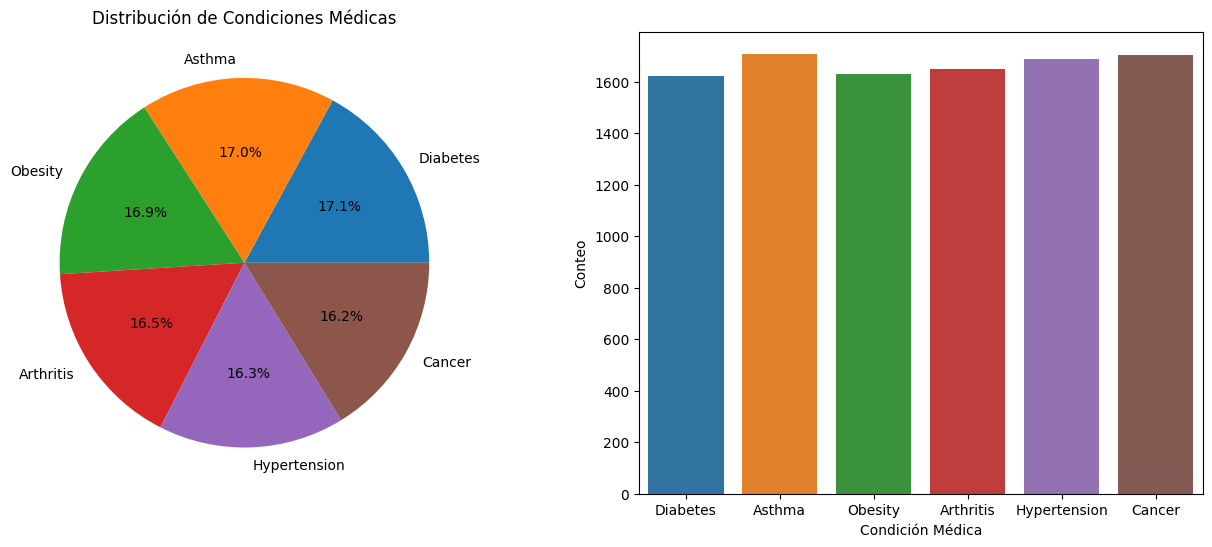

In [81]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.pie(data_eda['condición médica'].value_counts(), labels=data_eda['condición médica'].unique(), autopct='%1.1f%%')
plt.title('Distribución de Condiciones Médicas')
plt.subplot(1,2,2)
sns.countplot(x='condición médica', data=data_eda)
plt.xlabel('Condición Médica')
plt.ylabel('Conteo')
plt.show()

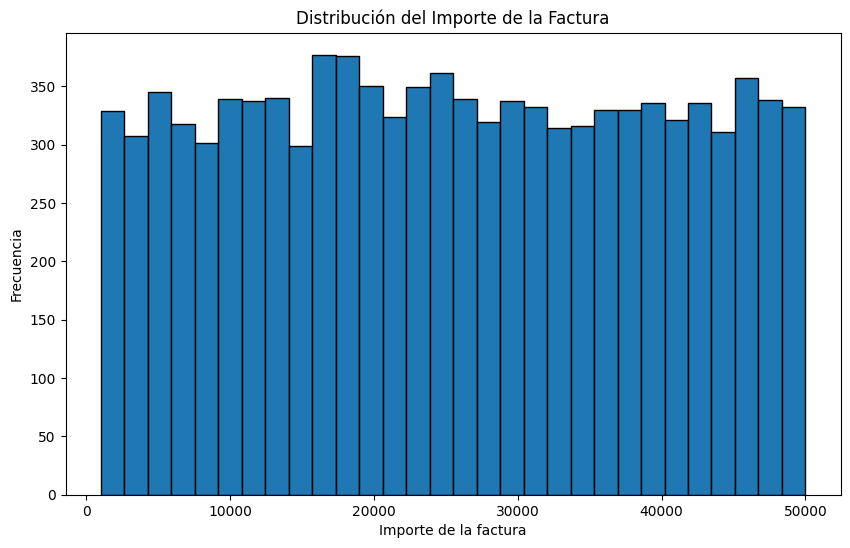

In [85]:
plt.figure(figsize=(10,6))
plt.hist(data_eda['Importe de la factura'], bins=30, edgecolor='black')
plt.xlabel('Importe de la factura')
plt.ylabel('Frecuencia')
plt.title('Distribución del Importe de la Factura')
plt.show()

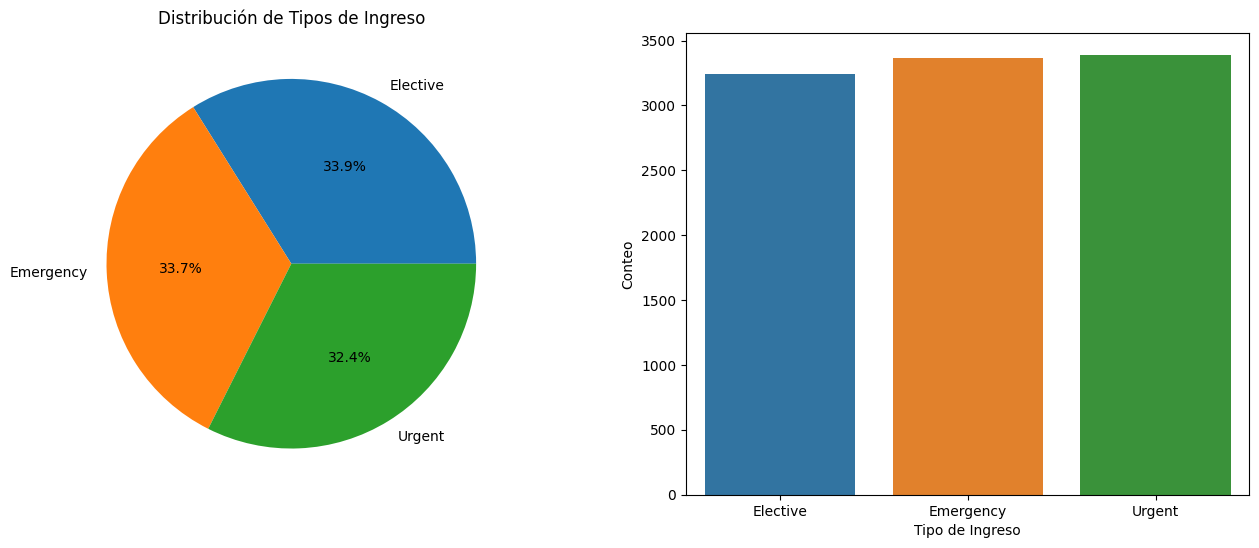

In [86]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.pie(data_eda['Tipo de ingreso'].value_counts(), labels=data_eda['Tipo de ingreso'].unique(), autopct='%1.1f%%')
plt.title('Distribución de Tipos de Ingreso')

plt.subplot(1,2,2)
sns.countplot(x='Tipo de ingreso', data=data_eda)
plt.xlabel('Tipo de Ingreso')
plt.ylabel('Conteo');
plt.show()


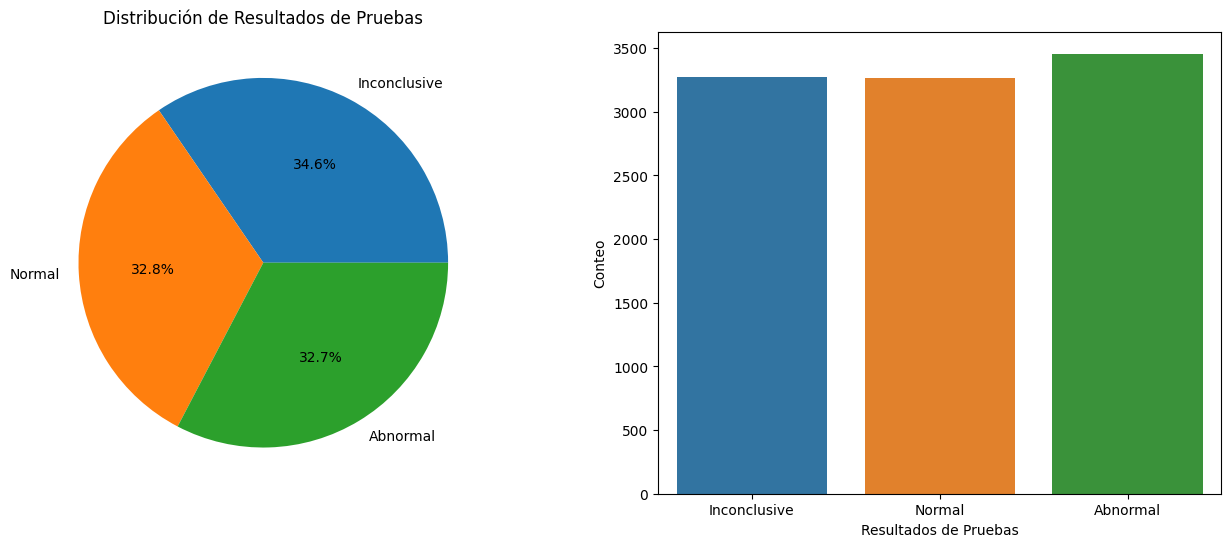

In [87]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.pie(data_eda['Resultados de pruebas'].value_counts(), labels=data_eda['Resultados de pruebas'].unique(), autopct='%1.1f%%')
plt.title('Distribución de Resultados de Pruebas')

plt.subplot(1,2,2)
sns.countplot(x='Resultados de pruebas', data=data_eda)
plt.xlabel('Resultados de Pruebas')
plt.ylabel('Conteo');
plt.show()

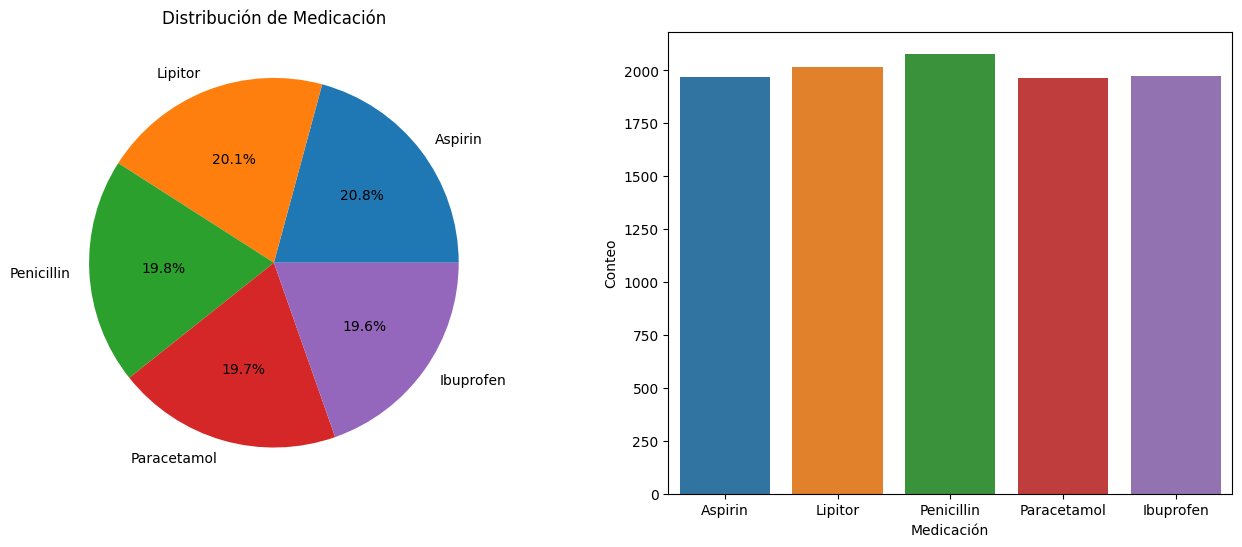

In [89]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.pie(data_eda['Medicación'].value_counts(), labels=data_eda['Medicación'].unique(), autopct='%1.1f%%')
plt.title('Distribución de Medicación')
plt.subplot(1,2,2)
sns.countplot(x='Medicación', data=data_eda)
plt.xlabel('Medicación')
plt.ylabel('Conteo');
plt.show()

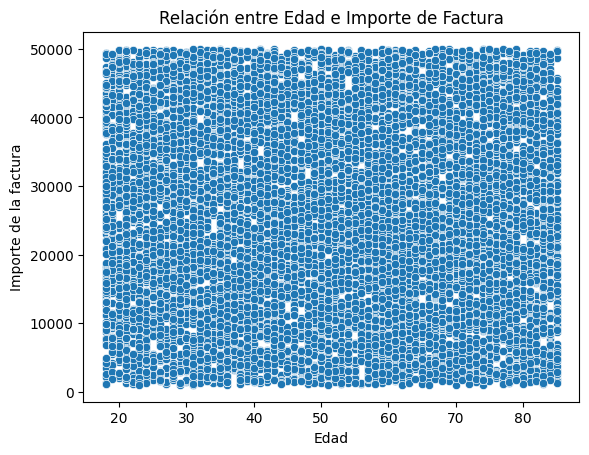

In [90]:
sns.scatterplot(x='Edad', y='Importe de la factura', data=data_eda)
plt.xlabel('Edad')
plt.ylabel('Importe de la factura')
plt.title('Relación entre Edad e Importe de Factura')
plt.show()

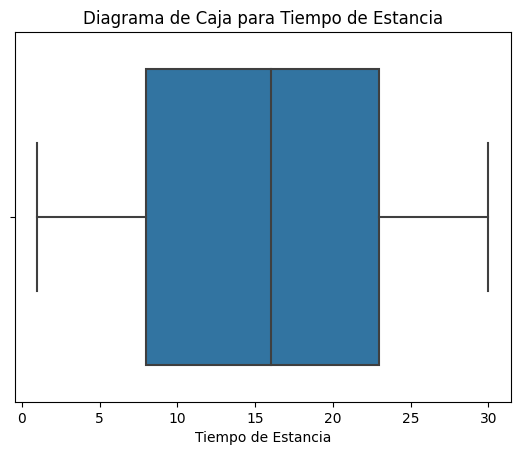

15.5618


In [92]:
sns.boxplot(x='Tiempo de estancia', data=data_eda)
plt.xlabel('Tiempo de Estancia')
plt.title('Diagrama de Caja para Tiempo de Estancia')
plt.show()
estancia = mean(data_eda["Tiempo de estancia"].to_list())
print(estancia)

Analizando las graficas podemos observar los siguientes aspectos:


*   El tiempo de estancia promedio invariante al hospital es de 15.56 dias o bien 16 dias
*   La distribución del medicamento es casi igual en porcentaje, lo cual pareceria que son casi uniformes los datos.

*   La distribución de las pruebas es casi igual en porcentaje, lo cual pareceria que son casi uniformes los datos.

*   La distribución del tipo de ingreso, tipo de sangre y condición médica es casi igual en porcentaje, lo cual pareceria que son casi uniformes los datos.
*   No podemos ver tendencia entre el importe de factura y la edad del paciente

In [96]:
# Estadísticas descriptivas por condición médica
stats_by_condition = data_eda.groupby('condición médica')['Importe de la factura'].describe()
stats_by_condition

,count,mean,std,min,25%,50%,75%,max
condición médica,,,,,,,,
Arthritis,1650.0,25187.631255,13765.174917,1009.417327,13754.426167,24739.166756,36579.125135,49985.973068
Asthma,1708.0,25416.869895,14346.784030,1032.263087,13252.508123,25073.451484,38069.759545,49974.299138
Cancer,1703.0,25539.096133,14081.988396,1020.337790,13345.089001,25610.641823,37712.877084,49994.984740
Diabetes,1623.0,26060.116129,14013.920497,1071.456127,14261.633315,26162.203248,38420.859483,49954.968325
Hypertension,1688.0,25198.033973,14137.135382,1084.422303,12710.162418,24920.455173,37773.133854,49995.902283
Obesity,1628.0,25720.842683,14040.788179,1000.180837,13784.850203,25365.022734,37751.714585,49974.160458


In [98]:
media_condicion = mean(stats_by_condition['mean'].to_list())
var_condicion = stdev(stats_by_condition['std'].to_list())
print(media_condicion,var_condicion)

25520.431677977198 188.6699841475095


Como dato adicional las medias y varianzas entre las condiciones medicas y el importe de la factura son casi iguales, no hay mucho cambio, lo cual, nos dice que sin importar la condición médica del paciente se estaria pagando casi el promedio de \$ 25520.431677977198 dolares. Con una diferencia entre enfermedad de aproximadamente \$ 188.6699841475095. dolares

# Modelo de Regresión Lineal para el importe de factura

In [105]:
reg_lin = data_dummy_sexo.copy()

In [106]:
resultados_dummy = pd.get_dummies(reg_lin["Resultados de pruebas"], prefix='Resultado')
reg_lin = pd.concat([reg_lin, resultados_dummy], axis=1)
reg_lin.head()

,Edad,Sexo,Tipo de sangre,condición médica,Fecha de admisión,Médico,Hospital,Proveedor de seguro,Importe de la factura,Tipo de ingreso,Fecha de alta,Medicación,Resultados de pruebas,Tiempo de estancia,Resultado_Abnormal,Resultado_Inconclusive,Resultado_Normal
0,81,0,O-,Diabetes,2022-11-17,Patrick Parker,Wallace-Hamilton,Medicare,37490.983364,Elective,2022-12-01,Aspirin,Inconclusive,14,0,1,0
1,35,1,O+,Asthma,2023-06-01,Diane Jackson,"Burke, Griffin and Cooper",UnitedHealthcare,47304.064845,Emergency,2023-06-15,Lipitor,Normal,14,0,0,1
2,61,1,B-,Obesity,2019-01-09,Paul Baker,Walton LLC,Medicare,36874.896997,Emergency,2019-02-08,Lipitor,Normal,30,0,0,1
3,49,1,B-,Asthma,2020-05-02,Brian Chandler,Garcia Ltd,Medicare,23303.322092,Urgent,2020-05-03,Penicillin,Abnormal,1,1,0,0
4,51,1,O-,Arthritis,2021-07-09,Dustin Griffin,"Jones, Brown and Murray",UnitedHealthcare,18086.344184,Urgent,2021-08-02,Paracetamol,Normal,24,0,0,1


**Consideraciones importantes** <br>
* **Edad:** La edad puede tener una relación con diversas condiciones médicas y el tiempo de estancia.<br>
* **Sexo:** Puedes incluirlo si se espera que el género tenga un impacto en el importe de la factura.<br>
* **Medicación:** Si la medicación tiene un costo y se espera que afecte el importe de la factura, sería una buena variable para incluir.<br>
* **Tiempo de Estancia:** Es probable que tenga una relación directa con el importe de la factura.<br>
* **Condiciones Médicas (Arthritis, Asthma, Cancer, Diabetes, Hypertension, Obesity):** Si estas condiciones médicas afectan los costos de la atención médica, serían buenas variables para incluir.<br>
* **Tipo de Ingreso (Elective, Emergency, Urgent):** Puede influir en los costos y la duración de la atención médica.<br>
* **Tipo de Sangre:** A menos que haya una razón específica para pensar que el tipo de sangre afecta los costos médicos, podría no ser relevantes

In [107]:
reg_lin = reg_lin.drop(["Fecha de admisión","Médico","Fecha de alta","Resultados de pruebas","Hospital"],axis=1)

**Se descompone en dos diferentes modelos, uno considerando que influye en algo el tipo de sangre y otro donde no se considera el tipo de sangre**

# Comprobación de relación entre variables para modelo sin tipo de sangre <br>
Para realizar esta tarea, necesitamos poder manejar variables binarias, por lo cual, haremos la transformación de las variables.

In [119]:
reg_lin_out_san =reg_lin.copy()

In [120]:
reg_lin_out_san = reg_lin_out_san.drop(["Tipo de sangre"],axis=1)

In [121]:
condicion = pd.get_dummies(reg_lin_out_san["condición médica"], prefix='CondicionMed')
tipo_ingreso = pd.get_dummies(reg_lin_out_san["Tipo de ingreso"], prefix='TipIng')
medicacion = pd.get_dummies(reg_lin_out_san["Medicación"], prefix='Med')
provedor = pd.get_dummies(reg_lin_out_san["Proveedor de seguro"], prefix='Prov_seg')
reg_lin_out_san = pd.concat([reg_lin_out_san,condicion,tipo_ingreso,medicacion,provedor], axis=1)

In [122]:
reg_lin_out_san.head()

,Edad,Sexo,condición médica,Proveedor de seguro,Importe de la factura,Tipo de ingreso,Medicación,Tiempo de estancia,Resultado_Abnormal,Resultado_Inconclusive,...,Med_Aspirin,Med_Ibuprofen,Med_Lipitor,Med_Paracetamol,Med_Penicillin,Prov_seg_Aetna,Prov_seg_Blue Cross,Prov_seg_Cigna,Prov_seg_Medicare,Prov_seg_UnitedHealthcare
0,81,0,Diabetes,Medicare,37490.983364,Elective,Aspirin,14,0,1,...,1,0,0,0,0,0,0,0,1,0
1,35,1,Asthma,UnitedHealthcare,47304.064845,Emergency,Lipitor,14,0,0,...,0,0,1,0,0,0,0,0,0,1
2,61,1,Obesity,Medicare,36874.896997,Emergency,Lipitor,30,0,0,...,0,0,1,0,0,0,0,0,1,0
3,49,1,Asthma,Medicare,23303.322092,Urgent,Penicillin,1,1,0,...,0,0,0,0,1,0,0,0,1,0
4,51,1,Arthritis,UnitedHealthcare,18086.344184,Urgent,Paracetamol,24,0,0,...,0,0,0,1,0,0,0,0,0,1


In [123]:
reg_lin_out_san = reg_lin_out_san.drop(["condición médica",	"Proveedor de seguro",  "Tipo de ingreso",	"Medicación"],axis=1)

In [124]:
reg_lin_out_san.head()

,Edad,Sexo,Importe de la factura,Tiempo de estancia,Resultado_Abnormal,Resultado_Inconclusive,Resultado_Normal,CondicionMed_Arthritis,CondicionMed_Asthma,CondicionMed_Cancer,...,Med_Aspirin,Med_Ibuprofen,Med_Lipitor,Med_Paracetamol,Med_Penicillin,Prov_seg_Aetna,Prov_seg_Blue Cross,Prov_seg_Cigna,Prov_seg_Medicare,Prov_seg_UnitedHealthcare
0,81,0,37490.983364,14,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,35,1,47304.064845,14,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,1
2,61,1,36874.896997,30,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,49,1,23303.322092,1,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
4,51,1,18086.344184,24,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,0,1


In [125]:
corr_matrix = reg_lin_out_san.corr()
positive_correlations = pd.DataFrame(columns=['Variable', 'Correlation'])
target_variable = 'Importe de la factura'

for column in corr_matrix.columns:
    if column != target_variable and corr_matrix[column][target_variable] > 0:
        positive_correlations = positive_correlations.append({
            'Variable': column,
            'Correlation': corr_matrix[column][target_variable]
        }, ignore_index=True);
# Mostrar el DataFrame con las correlaciones positivas
positive_correlations

<ipython-input-125-d6eee78dda87>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  positive_correlations = positive_correlations.append({
<ipython-input-125-d6eee78dda87>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  positive_correlations = positive_correlations.append({
<ipython-input-125-d6eee78dda87>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  positive_correlations = positive_correlations.append({
<ipython-input-125-d6eee78dda87>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  positive_correlations = positive_correlations.append({
<ipython-input-125-d6eee78dda87>:7: FutureWarning: The frame.append method is deprecated and wil

,Variable,Correlation
0,Sexo,0.002340
1,Resultado_Abnormal,0.001095
2,Resultado_Inconclusive,0.007988
3,CondicionMed_Cancer,0.000718
4,CondicionMed_Diabetes,0.017001
5,CondicionMed_Obesity,0.006396
6,TipIng_Elective,0.018466
7,TipIng_Urgent,0.022611
8,Med_Aspirin,0.009812
9,Med_Lipitor,0.021765


Al realizar una matriz de correlación, obtenemos solo las variables correlacionadas positivamente. Por ello solo se van a considerar esas variables

# Modelo sin tipo de sangre



In [126]:
variables_x = positive_correlations["Variable"].to_list()
reg_lin_out_san['constante'] = 1
X = reg_lin_out_san[variables_x + ['constante']]
y = reg_lin_out_san[ 'Importe de la factura']
modelo_out_sangre = sm.OLS(y, X).fit()
print(modelo_out_sangre.summary())

                              OLS Regression Results                             
Dep. Variable:     Importe de la factura   R-squared:                       0.003
Model:                               OLS   Adj. R-squared:                  0.002
Method:                    Least Squares   F-statistic:                     2.553
Date:                   Sat, 25 Nov 2023   Prob (F-statistic):            0.00161
Time:                           19:40:59   Log-Likelihood:            -1.0969e+05
No. Observations:                  10000   AIC:                         2.194e+05
Df Residuals:                       9986   BIC:                         2.195e+05
Df Model:                             13                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

El modelo de regresión lineal muestra un coeficiente de determinación ($R^2$) de 0.003, lo que sugiere alrededor del 0.3% de la variabilidad en el importe de la factura puede ser explicada por las variables incluidas en el modelo. Este bajo $R^2$.<br>
Esto indica que el modelo no proporciona una explicación sustancial de la variabilidad observada en la variable de respuesta.<br>
**Analisis de las variables redictoras**<br>

> Algunas de ellas tienen p-values significativos, mientras que otras no. <br>


**Variable con significancia**<br>

> "CondicionMed_Diabetes" y "TipIng_Urgent" tienen p-values inferiores a 0.05, lo que sugiere que podrían tener un impacto significativo en el importe de la factura. <br>


**Variables sin significancia.**<br>


> "Sexo" y "Resultado_Abnormal" tienen p-values mayores a 0.05, indicando que no hay evidencia significativa para sugerir que están relacionadas con el importe de la factura.


In [141]:
variables_x = ["TipIng_Elective","TipIng_Urgent","Med_Lipitor"]
reg_lin_out_san['constante'] = 1
X = reg_lin_out_san[variables_x + ['constante']]
y = reg_lin_out_san[ 'Importe de la factura']
modelo_out_sangre = sm.OLS(y, X).fit()
print(modelo_out_sangre.summary())

                              OLS Regression Results                             
Dep. Variable:     Importe de la factura   R-squared:                       0.002
Model:                               OLS   Adj. R-squared:                  0.002
Method:                    Least Squares   F-statistic:                     7.184
Date:                   Sat, 25 Nov 2023   Prob (F-statistic):           8.17e-05
Time:                           20:02:28   Log-Likelihood:            -1.0969e+05
No. Observations:                  10000   AIC:                         2.194e+05
Df Residuals:                       9996   BIC:                         2.194e+05
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
TipIng_Elect

Se realizo el modelo de regresión lineal, tomando en cuenta solo las variables con mejor P-value, y aun asi no se logra mejorar el resultado de nuestra $R^2$ <br>
Por esta razon, no podemos realizar un modelo de regresión lineal funcional, lo cual implica que si alimentamos un algoritmo de aprendizaje, tendra muchas precariedades, además, de que la relación entre variable es completamente fatal.<br>

**Se realizara un modelo de regresión lineal, considerando el proveedor, y el tipo de sangre**<br>

**No se considera el hospital porque generaria una gran cantidad de variables dummy, lo cual nos haria un gran gasto de memoria y tiempo**

# Modelo de regresion con tipo de Sangre

In [142]:
reg_lin_san = reg_lin.copy()

In [143]:
tipo_sangre = pd.get_dummies(reg_lin_san["Tipo de sangre"], prefix='Sangre')
condicion = pd.get_dummies(reg_lin_san["condición médica"], prefix='CondicionMed')
tipo_ingreso = pd.get_dummies(reg_lin_san["Tipo de ingreso"], prefix='TipIng')
medicacion = pd.get_dummies(reg_lin_san["Medicación"], prefix='Med')
provedor = pd.get_dummies(reg_lin_san["Proveedor de seguro"], prefix='Prov_seg')
reg_lin_san = pd.concat([reg_lin_san, tipo_sangre,condicion,tipo_ingreso,medicacion,provedor], axis=1)

<ipython-input-144-ac4e4de90891>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = reg_lin_san.corr()


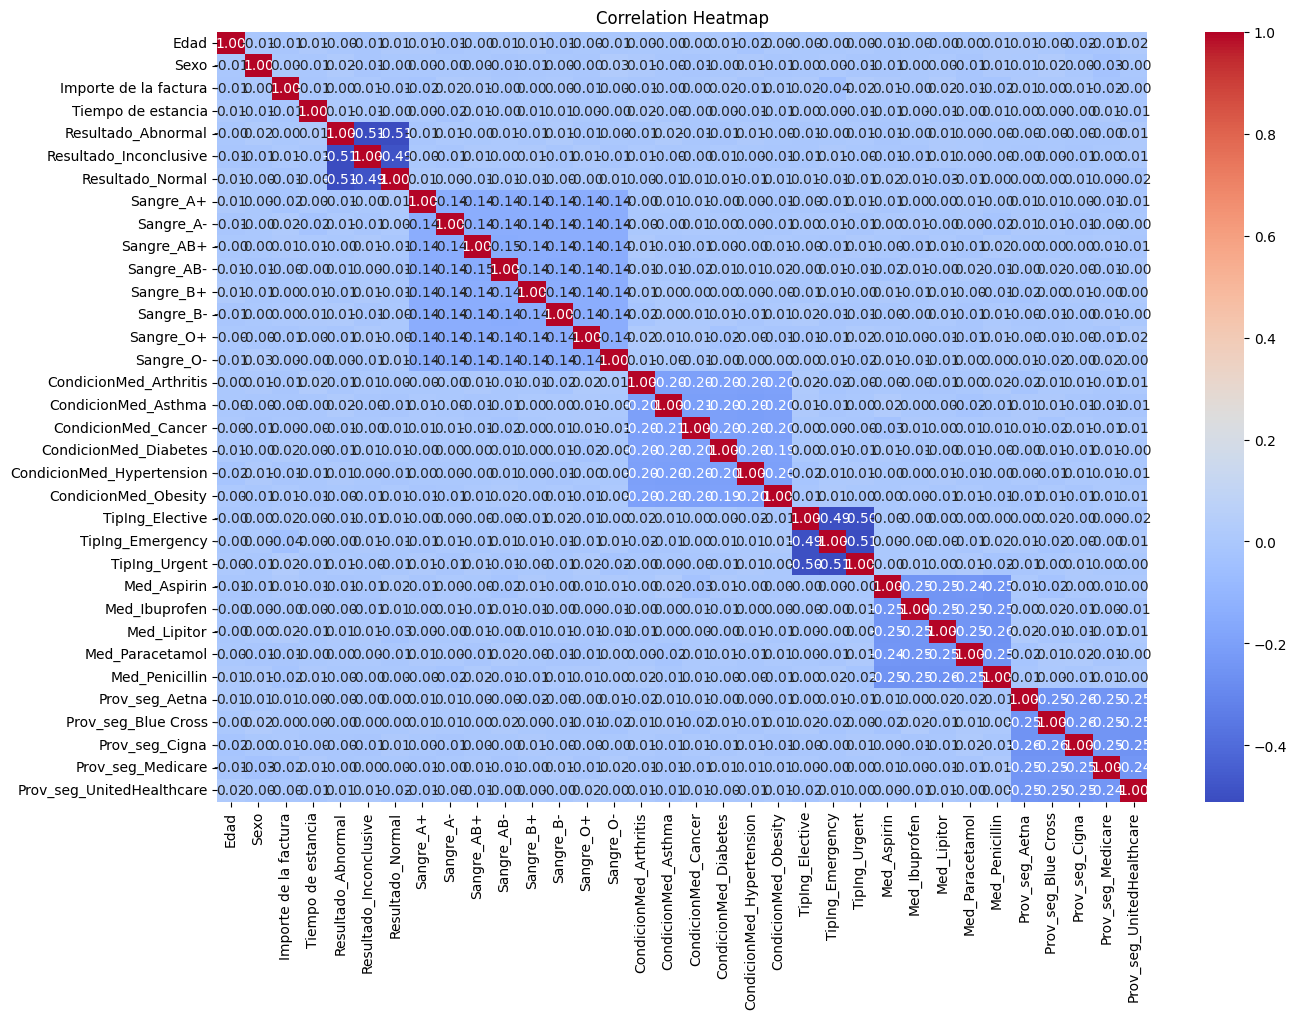

In [144]:
corr_matrix = reg_lin_san.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Es facil observar que no hay mucha correlación entre las variables, es por ello que solamente nos quedaremos con las de mayor correlación con respecto al "Importe de facturas"

In [145]:
corr_matrix = reg_lin_san.corr()
positive_correlations = pd.DataFrame(columns=['Variable', 'Correlation'])
target_variable = 'Importe de la factura'

for column in corr_matrix.columns:
    if column != target_variable and corr_matrix[column][target_variable] > 0:
        positive_correlations = positive_correlations.append({
            'Variable': column,
            'Correlation': corr_matrix[column][target_variable]
        }, ignore_index=True);
# Mostrar el DataFrame con las correlaciones positivas
positive_correlations

<ipython-input-145-bada0e47dca6>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = reg_lin_san.corr()
<ipython-input-145-bada0e47dca6>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  positive_correlations = positive_correlations.append({
<ipython-input-145-bada0e47dca6>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  positive_correlations = positive_correlations.append({
<ipython-input-145-bada0e47dca6>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  positive_correlations = positive_correlations.append({
<ipython-input-145-bada0e47dca6>:7

,Variable,Correlation
0,Sexo,2.339709e-03
1,Resultado_Abnormal,1.094809e-03
2,Resultado_Inconclusive,7.988251e-03
3,Sangre_A-,1.949806e-02
4,Sangre_AB+,1.068717e-02
5,Sangre_B+,4.105057e-07
6,Sangre_B-,4.327804e-03
7,Sangre_O-,1.252536e-03
8,CondicionMed_Cancer,7.178860e-04
9,CondicionMed_Diabetes,1.700096e-02


In [148]:
variables_x = positive_correlations["Variable"].to_list()
reg_lin_san['constante'] = 1
X = reg_lin_san[variables_x + ['constante']]
y = reg_lin_san[ 'Importe de la factura']
modelo_sangre = sm.OLS(y, X).fit()
print(modelo_sangre.summary())

                              OLS Regression Results                             
Dep. Variable:     Importe de la factura   R-squared:                       0.004
Model:                               OLS   Adj. R-squared:                  0.002
Method:                    Least Squares   F-statistic:                     2.288
Date:                   Sat, 25 Nov 2023   Prob (F-statistic):            0.00146
Time:                           20:12:51   Log-Likelihood:            -1.0968e+05
No. Observations:                  10000   AIC:                         2.194e+05
Df Residuals:                       9981   BIC:                         2.195e+05
Df Model:                             18                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

# Conlcusión <br>
No es posible realizar un modelo de regresion lineal para obtener los pronosticos del importe de facturas, dado que no existe tanta correlación entre las variables de la base de datos, esto puede ser posible por ser una base de datos simulada, además de que esta base de datos es un poco erronea en cuestion de medicamentos, porque no se tratan esas enfermedades con ese tipo de medicamentos, además de que los precios son cuasi-igualmente distribuidos entre las variables de Tiempo de estancia, condición médica, tipo de prueba, tipo de ingreso,etc. <br><br>
Normalmente se esperaria que conforme pasen los dias dia, tipo de medicamento, proveedor de seguro, hospital, enfermedad y edad, exista un incremento en el importe de la factura, no es tan posible asegurar que se espere lo mismo por el tipo de sangre y sexo, pero es un aspecto interesante de investigar.<br>

